In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

In [9]:
rng = np.random.RandomState(seed=1)
m1 = np.load('../matrices/2024_FULL-STACK.npy')
X = np.random.choice(m1[m1!=0.0].flatten(), (100000,1))

In [10]:
k_arr = np.arange(10) + 1
models = [
    GaussianMixture(n_components=k).fit(X)
    for k in k_arr
]

In [11]:
# Plot function
def plot_mixture(gmm, X, show_legend=True, ax=None):
    if ax is None:
        ax = plt.gca()

    # Compute PDF of whole mixture
    x = np.linspace(8000, 14000, 5000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)

    # Compute PDF for each component
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    # Plot data histogram
    ax.hist(X, 1000, density=True, histtype='stepfilled', alpha=0.4, label ='Data')

    # Plot PDF of whole model
    ax.plot(x, pdf, '-k', label='Mixture PDF')
    
    # Plot PDF of each component
    ax.plot(x, pdf_individual, '--', label='Component PDF')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    if show_legend:
        ax.legend()

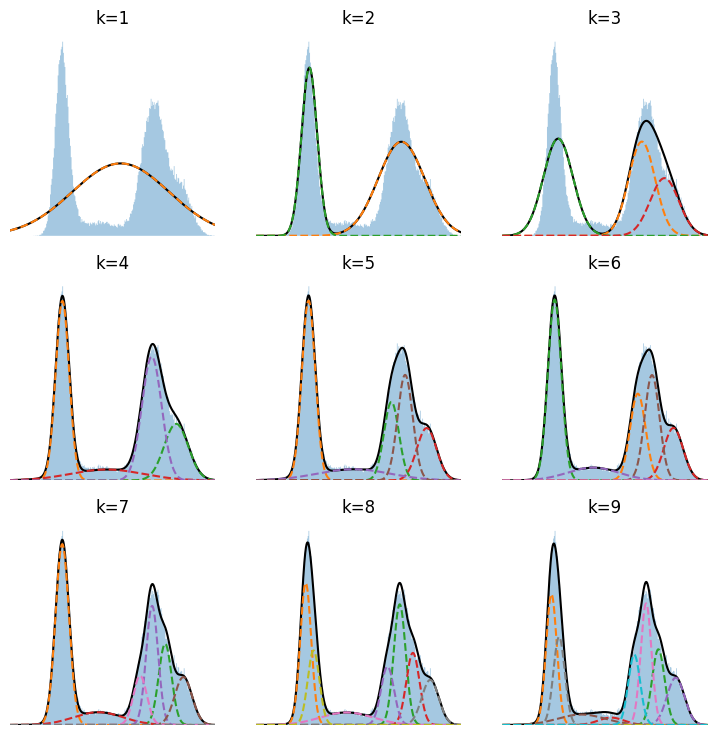

In [12]:
# Show all models for n_components 1 to 9
_, axes = plt.subplots(3,3,figsize=np.array([3,3])*3, dpi=100)
for gmm, ax in zip(models, axes.ravel()):
    plot_mixture(gmm, X, show_legend=False, ax=ax)
    ax.set_title(f'k={gmm.n_components}')
    ax.set_xlim(9000, 13000)
    ax.axis('off')
plt.tight_layout
plt.show()

In [13]:
model = models[4]

In [14]:
m = model.means_
w = model.weights_
cov = model.covariances_

In [15]:
print(m)
print(w)
print(cov)

[[10021.26648158]
 [11636.69189707]
 [12324.14800244]
 [10899.82468727]
 [11903.96266253]]
[0.34375917 0.16750451 0.14630859 0.11600066 0.22642708]
[[[ 17125.43691187]]

 [[ 21322.27149273]]

 [[ 36592.17763922]]

 [[504701.15408158]]

 [[ 21567.65299125]]]


(0.0, 1.0, 1.0)
(0.2, 0.8, 1.0)
(0.4, 0.6, 1.0)
(0.6000000000000001, 0.3999999999999999, 1.0)
(0.8, 0.19999999999999996, 1.0)


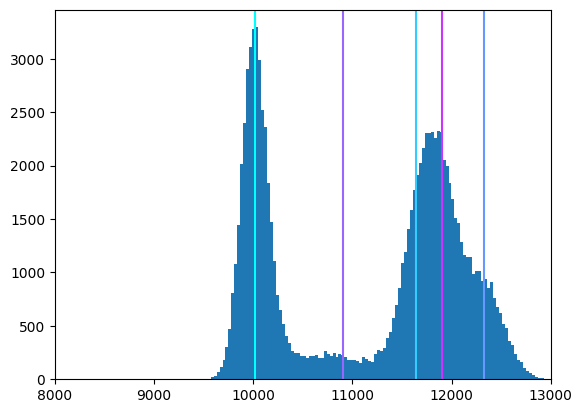

In [24]:
plt.hist(X, 500)

i=0
for mean in m:
    col = (i*0.2, 1-i*0.2, 1.0)
    plt.axvline(mean, color=col)
    print(col)
    i+=1

plt.xlim(8000,13000)
plt.show()